#

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs   
import matplotlib.pyplot as plt
from matplotlib import colorbar

#adds cyclic point to rearragne the grid for a plotting prijection
def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0] # size of POP grid
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data

    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
   
    if ni == 320: # this is the x1 POP grid
        print('\n')

    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point

    if ni == 320:
        print('\n')

   
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

In [2]:
#open the case 
caseName = 'MAA2.1.3_CAM4_POP2_CLM4_RTMEBM_CICE4_SGLC_T31_g37_1850_FORCINGFILESTEST02'
casePath = '/glade/scratch/jcoupe/archive/MAA2.1.3_CAM4_POP2_CLM4_RTMEBM_CICE4_SGLC_T31_g37_1850_FORCINGFILESTEST02/ocn/hist/'

temp=xr.open_mfdataset(casePath + caseName+'.pop.h.0001-12'+'.nc')

In [3]:
#run the pop function to rearrange the grid
temp_pop = pop_add_cyclic(temp)

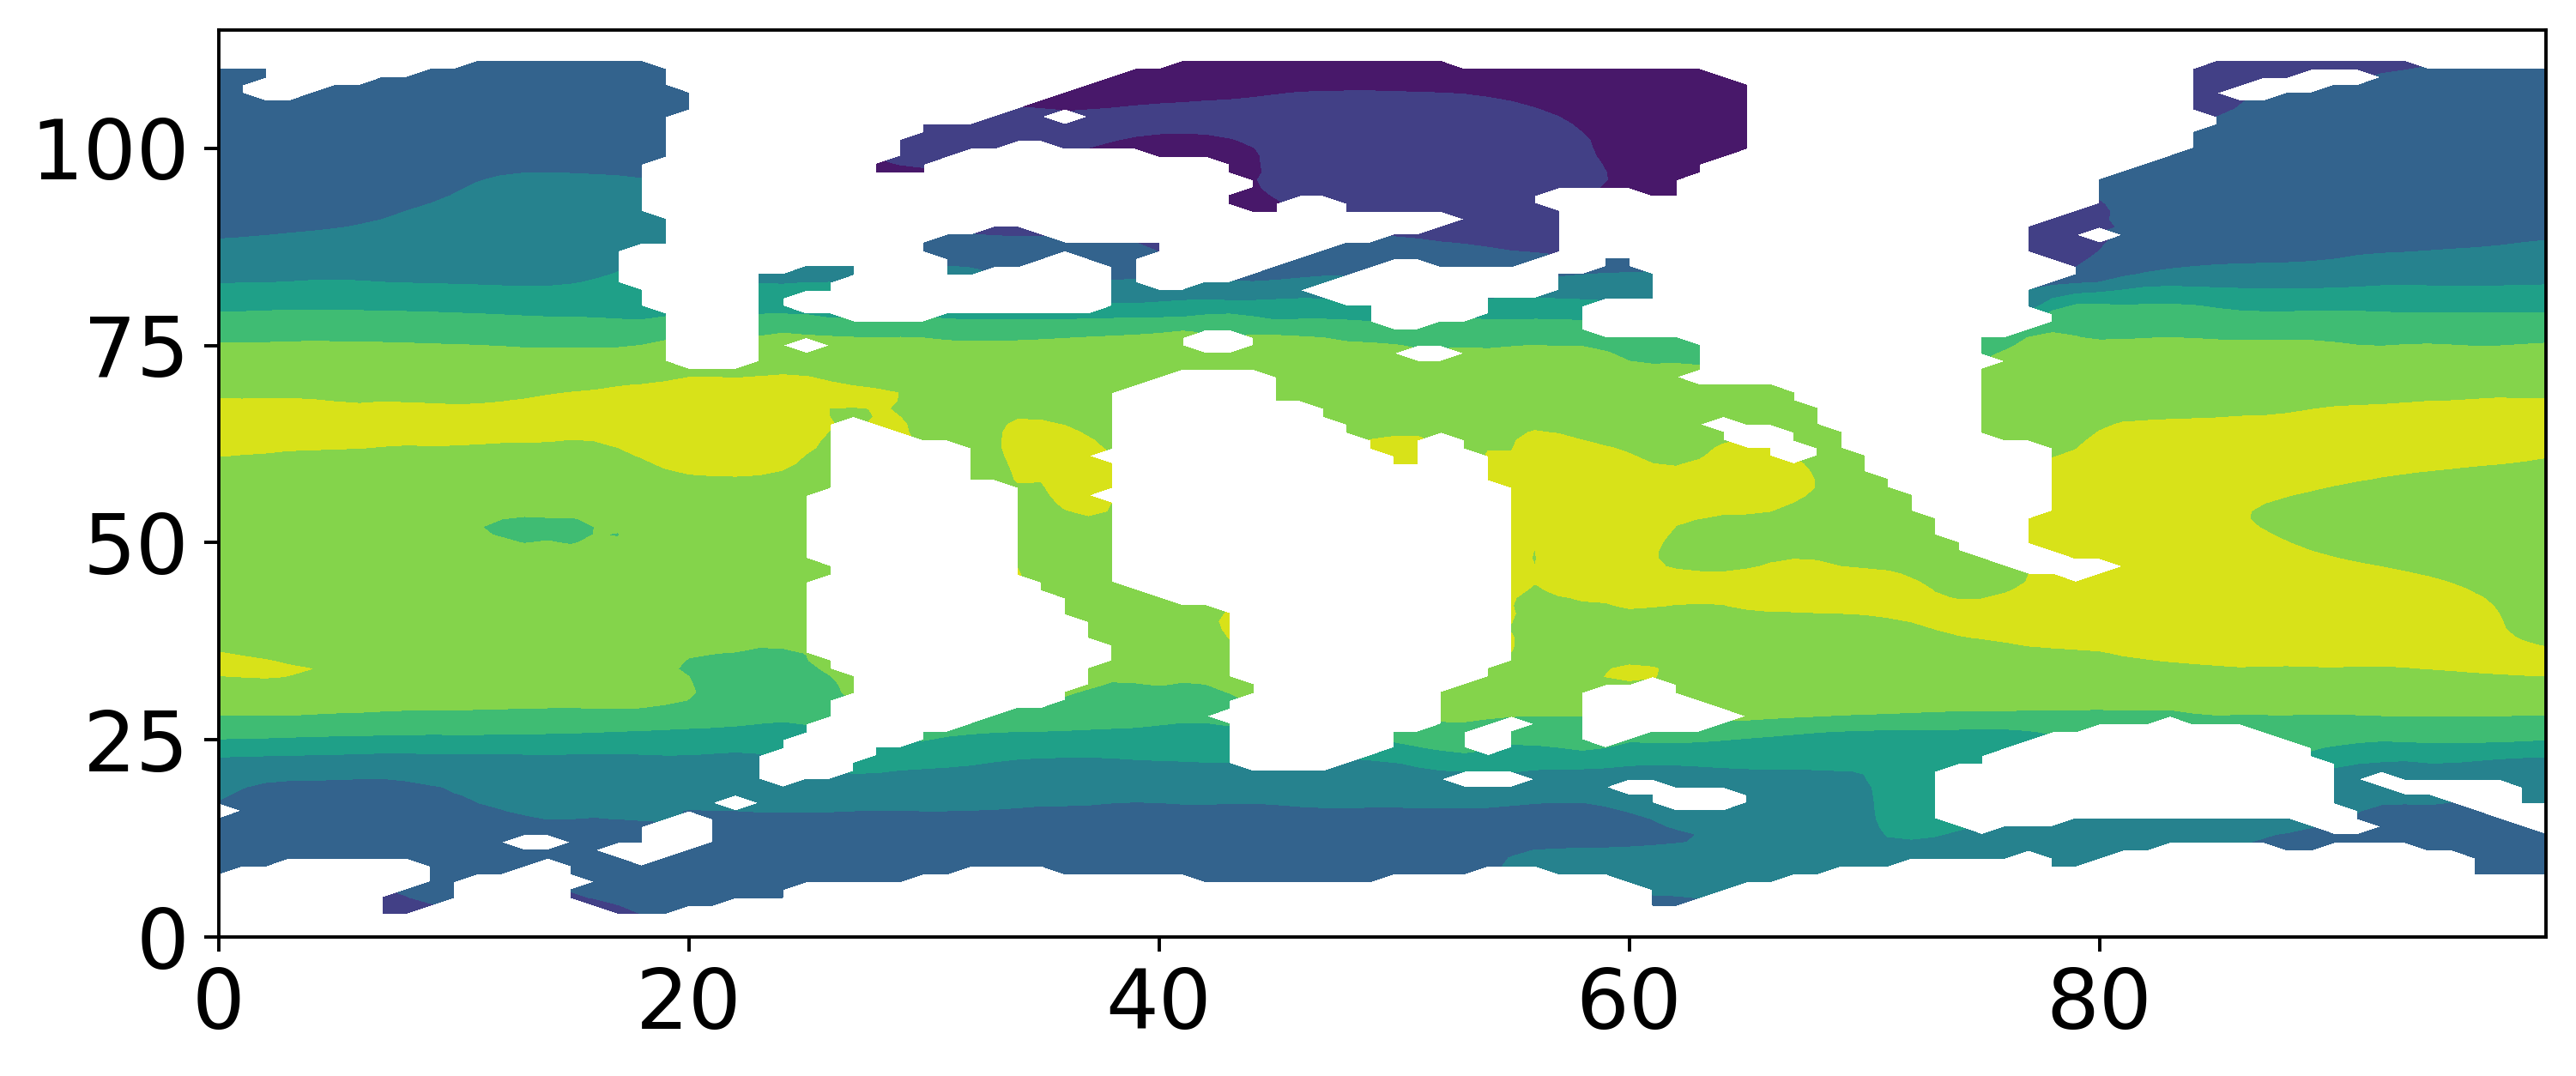

In [5]:
#A quick look at the data
plt.contourf(temp['TEMP'][0,0,:,:])

In [8]:
temp_pop['TEMP']

<xarray.DataArray 'TEMP' (time: 1, z_t: 60, nlat: 116, nlon: 101)>
dask.array<concatenate, shape=(1, 60, 116, 101), dtype=float32, chunksize=(1, 60, 116, 51), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0002-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/dask/array/core.py:4209: RuntimeWarning: invalid value encountered in greater_equal
  result = function(*args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


-80.0016984952053


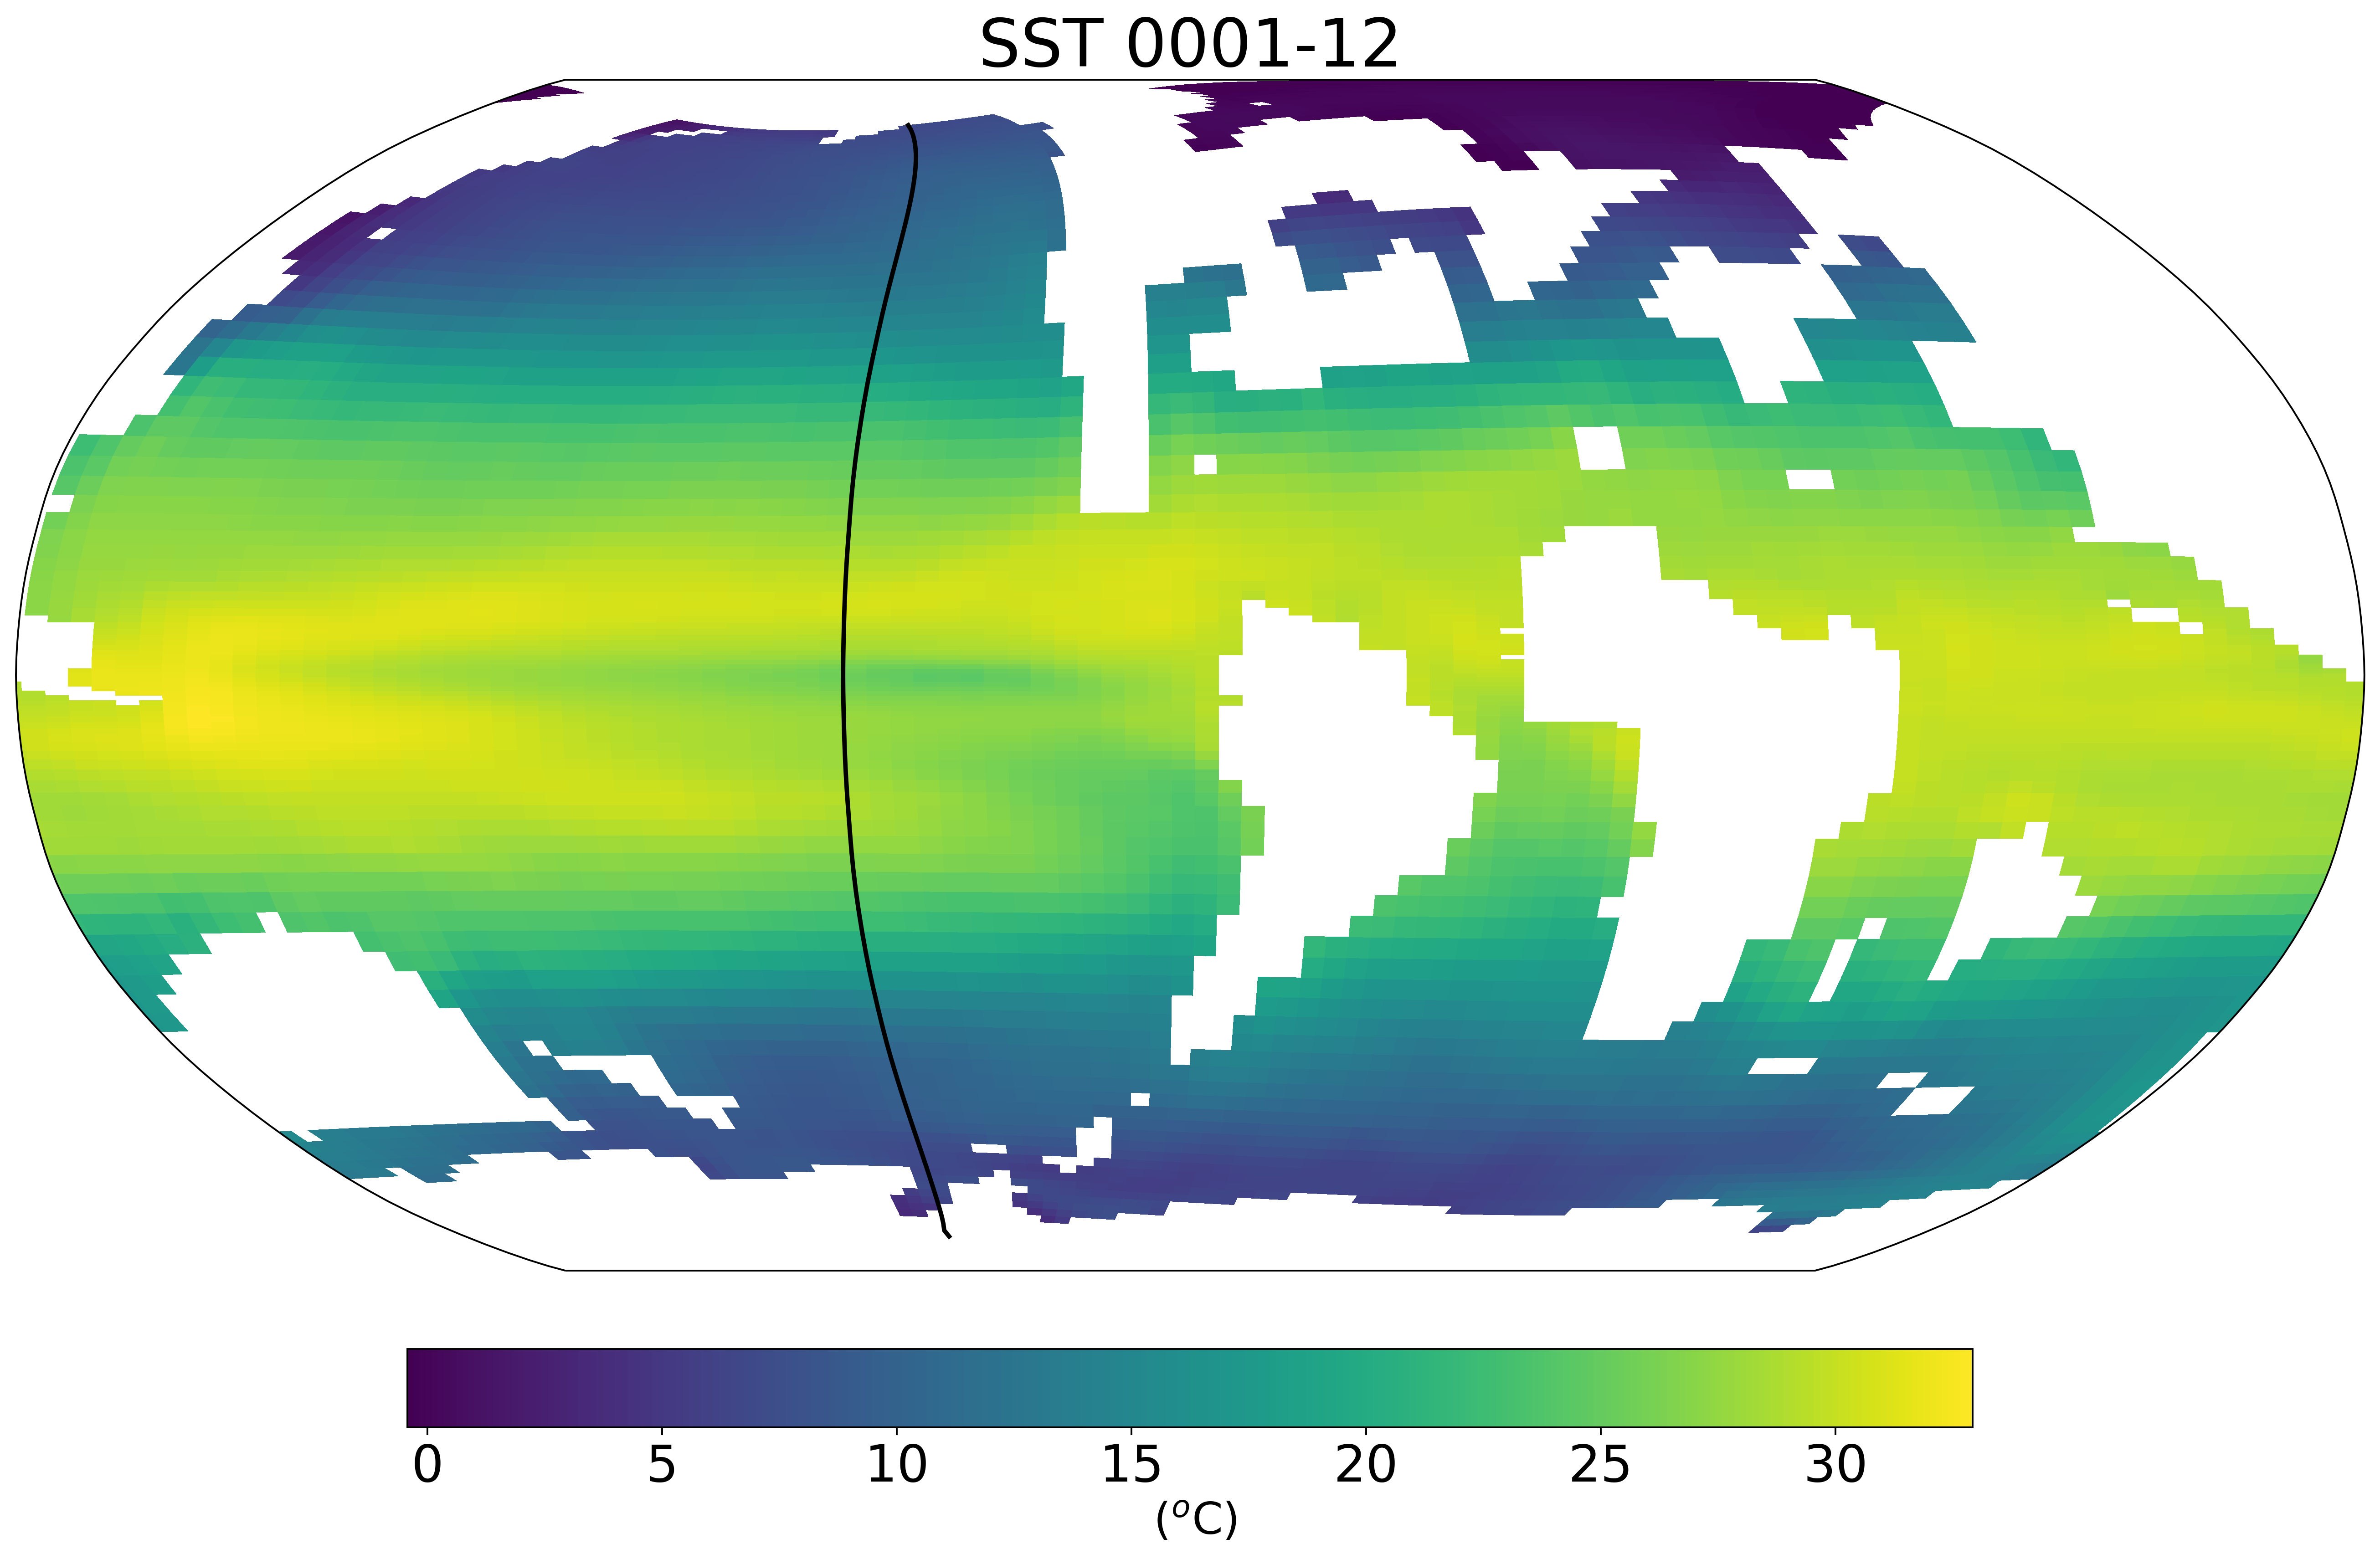

In [25]:
#extract the long and lat valkues from the rearranged pop grid
x,y = temp_pop.variables['TLONG'], temp_pop.variables['TLAT']

fig,ax= plt.subplots(figsize =(19,13),facecolor='w',subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-60))) 
ax.set_global()

#use pcolor to plot the temperature, similar to all of the others
p = ax.pcolor(x, y,temp_pop['TEMP'][0,0,:,:], transform=ccrs.PlateCarree())

#add the colorbar to the plots
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax)
cbar.ax.tick_params(labelsize=23)
cbar.set_label(' ($^o$C) ')

#add a line to visualize the longitude
plt.plot(temp['TLONG'][:,10].values,temp['TLAT'][:,10].values,color='k', transform=ccrs.PlateCarree(),zorder=10)
print(temp_pop.TLAT[0,56].values)


plt.title('SST 0001-12' , size = 30)
